In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import optimizers
from keras import backend as K

input_img = Input(shape=(128, 128, 1))  # adapt this if using `channels_first` image data format

# Encode-----------------------------------------------------------
x = Conv2D(32, (4, 4), strides=2 , activation='relu', padding='same')(input_img)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
encoded = Conv2D(1, (8, 8), strides=1, padding='same')(x)

# Decode---------------------------------------------------------------------
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(encoded)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (8, 8), activation='sigmoid', padding='same')(x)
# ---------------------------------------------------------------------
autoencoder = Model(input_img, decoded)
adam = optimizers.Adam(lr=0.0002, decay=0.00001)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

C:\Users\NSW00_906882\AppData\Local\Continuum\anaconda3\envs\ssd2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        544       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         131200    
__________

In [2]:
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

# Own Your Image Directory
img_dir = ("./Samples/")
img_files = glob.glob(img_dir + "*.jpeg")
# Setting Image Propertie
width = 128
height = 128
pixels = width * height * 1 # gray scale 

# Load Image
# AutoEncoder does not have to label data 
x = []

for i, f in enumerate(img_files):
    img = Image.open(f)
#     img = img.convert("RGB")
    img = img.convert("L") # gray sclae
    img = img.resize((width,height), 1)
    data = np.asarray(img)
    x.append(data)
    if i % 10 == 0:
        print(i, "\n", data)

x = np.array(x)
(x_train, x_test) = train_test_split(x, shuffle=False, train_size=0.8, random_state=1)

img_list = (x_train, x_test)
np.save("./obj.npy", img_list)
print("OK", len(x)) 

0 
 [[ 65  85  94 ... 225 231 235]
 [ 61  76  94 ... 213 222 233]
 [ 57  63  90 ... 190 213 222]
 ...
 [190 188 187 ... 132  89  93]
 [185 184 182 ... 123 134 156]
 [180 179 176 ... 117 173 159]]
OK 10


C:\Users\NSW00_906882\AppData\Local\Continuum\anaconda3\envs\ssd2\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
# change to float32
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 128, 128, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 128, 128, 1))  # adapt this if using `channels_first` image data format
print (x_train.shape)
print (x_test.shape)

(8, 128, 128, 1)
(2, 128, 128, 1)


In [4]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 8 samples, validate on 2 samples
Epoch 1/1000
8/8 [==============================] - 2s 218ms/step - loss: 0.6933 - val_loss: 0.6946
Epoch 2/1000
8/8 [==============================] - 1s 184ms/step - loss: 0.6923 - val_loss: 0.6982
Epoch 3/1000
8/8 [==============================] - 2s 191ms/step - loss: 0.6900 - val_loss: 0.7159
Epoch 4/1000
8/8 [==============================] - 1s 172ms/step - loss: 0.6766 - val_loss: 1.0087
Epoch 5/1000
8/8 [==============================] - 2s 194ms/step - loss: 0.7990 - val_loss: 0.7318
Epoch 6/1000
8/8 [==============================] - 1s 185ms/step - loss: 0.6676 - val_loss: 0.7086
Epoch 7/1000
8/8 [==============================] - 1s 180ms/step - loss: 0.6831 - val_loss: 0.7034
Epoch 8/1000
8/8 [==============================] - 1s 176ms/step - loss: 0.6872 - val_loss: 0.7016
Epoch 9/1000
8/8 [==============================] - 1s 175ms/step - loss: 0.6884 - val_loss: 0.7010
Epoch 10/1000
8/8 [==============================] - 1s 17

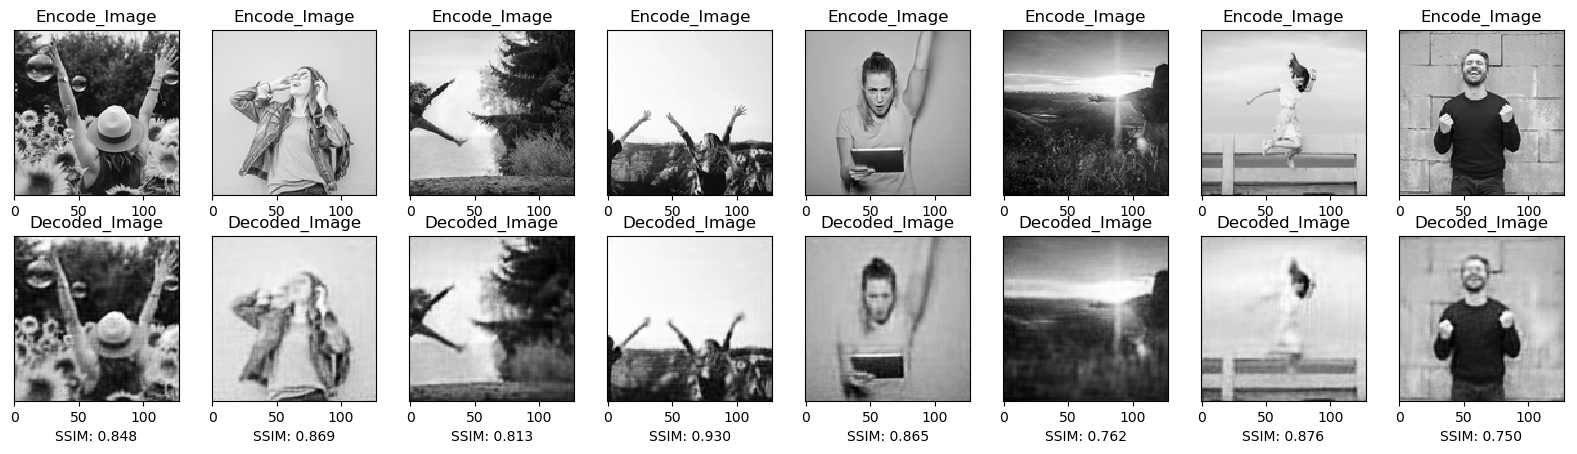

In [6]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_train)

n = 8  # how many digits we will display
plt.figure(figsize=(20, 5), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    
    # SSIM Encode
    ax.set_title("Encode_Image")
    
    npImg = x_train[i]
    npImg = npImg.reshape((128,128))
    formatted = (npImg * 255 / np.max(npImg)).astype('uint8')
    img = Image.fromarray(formatted)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    
    # SSIM Decoded    
    npDecoded = decoded_imgs[i]
    npDecoded = npDecoded.reshape((128,128))
    formatted2 = (npDecoded * 255 / np.max(npDecoded)).astype('uint8')
    decoded = Image.fromarray(formatted2)
    
    from SSIM_PIL import compare_ssim as ssim
    value = ssim(img, decoded)

    label = 'SSIM: {:.3f}'
    
    ax.set_title("Decoded_Image")
    ax.set_xlabel(label.format(value))

plt.show()